In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from slam.gridmap import GridMap
from slam.utils import bresenham_line

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)

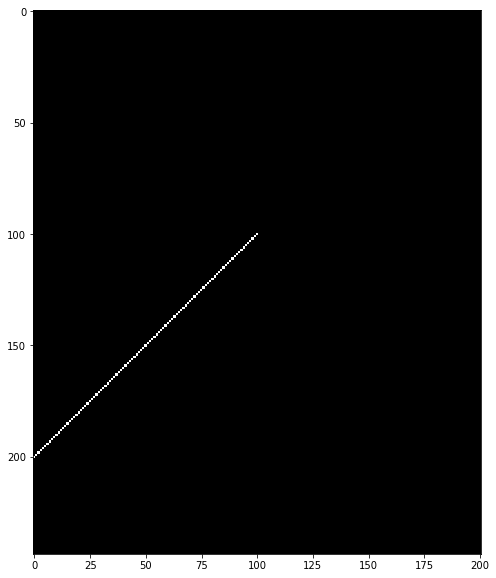

In [4]:
grid_map = GridMap('./data/laser_struct.mat')

points = bresenham_line((100, 100), (0, 200))

for point in points:
    px, py = point
    grid_map._grid_map[py, px] = 1

plt.imshow(grid_map._grid_map, cmap='gray')